In [1]:
# ===================================================================
# 1. Setup and Imports
# ===================================================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import optuna
import torch

# Scikit-learn & TabNet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from pytorch_tabnet.tab_model import TabNetRegressor

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Statsmodels for stationarity test
from statsmodels.tsa.stattools import adfuller

# Configuration
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
tf.random.set_seed(42)
np.random.seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# ===================================================================
# 2. Data Acquisition and Advanced Feature Engineering
# ===================================================================
print("Step 1: Downloading and preparing data with advanced features...")
variables = {
    "IHSG": "^JKSE", "S&P 500": "^GSPC", "Nasdaq": "^IXIC",
    "Crude Oil (WTI)": "CL=F", "Gold": "GC=F", "USD/IDR": "IDR=X",
    "DAX": "^GDAXI", "Crude Oil (Brent)": "BZ=F", "Copper": "HG=F"
}
data_ohlc = yf.download(list(variables.values()), start="2010-01-01", end=datetime.now().strftime('%Y-%m-%d'))
data = data_ohlc['Close'].copy()
data.rename(columns={v: k for k, v in variables.items()}, inplace=True)
data = data.ffill().bfill()

# Feature Engineering
data['MA10'] = data['IHSG'].rolling(window=10).mean()
data['MA50'] = data['IHSG'].rolling(window=50).mean()
delta = data['IHSG'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI14'] = 100 - (100 / (1 + rs))
data['BB_Mid'] = data['IHSG'].rolling(window=20).mean()
data['BB_Std'] = data['IHSG'].rolling(window=20).std()
data['BB_Upper'] = data['BB_Mid'] + (data['BB_Std'] * 2)
data['BB_Lower'] = data['BB_Mid'] - (data['BB_Std'] * 2)
high_low = data_ohlc['High']['^JKSE'] - data_ohlc['Low']['^JKSE']
high_close = np.abs(data_ohlc['High']['^JKSE'] - data['IHSG'].shift())
low_close = np.abs(data_ohlc['Low']['^JKSE'] - data['IHSG'].shift())
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
data['ATR'] = tr.rolling(window=14).mean()
low_14 = data_ohlc['Low']['^JKSE'].rolling(window=14).min()
high_14 = data_ohlc['High']['^JKSE'].rolling(window=14).max()
data['%K'] = 100 * ((data['IHSG'] - low_14) / (high_14 - low_14))
data['%D'] = data['%K'].rolling(window=3).mean()
for col in variables.keys():
    if col != 'IHSG':
        data[f'{col}_pct_change_1d'] = data[col].pct_change(1)
        data[f'{col}_pct_change_5d'] = data[col].pct_change(5)
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data.dropna(inplace=True)
print(f"Data shape after feature engineering: {data.shape}")

# ===================================================================
# 2.5. Stationarity Analysis (ADF Test)
# ===================================================================
print("\nStep 2.5: Performing Stationarity Analysis...")

def perform_adf_test(series, series_name):
    """Performs and prints the results of the Augmented Dickey-Fuller test."""
    result = adfuller(series)
    print(f'--- ADF Test Results for {series_name} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] <= 0.05:
        print("Conclusion: Reject the null hypothesis. Data is likely stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis. Data is likely non-stationary.")
    print("-" * 40)

# Test on the original price series
perform_adf_test(data['IHSG'], "IHSG Price Series")

# Test on the differenced (return) series
perform_adf_test(data['IHSG'].pct_change(1).dropna(), "IHSG Return Series")

# ===================================================================
# 3. Data Preparation: Predicting Returns
# ===================================================================
print("\nStep 3: Preparing data for modeling (predicting returns)...")
data['Target'] = data['IHSG'].pct_change(1).shift(-1)
data.dropna(inplace=True)
features = [col for col in data.columns if col not in ['Target', 'IHSG']]
X = data[features]
y = data['Target']
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")


/home/rangga/metopen/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-09 12:55:22.606085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752040522.633658  217372 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752040522.641087  217372 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752040522.666631  217372 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0

Step 1: Downloading and preparing data with advanced features...


[*********************100%***********************]  9 of 9 completed


Data shape after feature engineering: (1762, 37)

Step 2.5: Performing Stationarity Analysis...
--- ADF Test Results for IHSG Price Series ---
ADF Statistic: -1.9533
p-value: 0.3074
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -2.5676
Conclusion: Fail to reject the null hypothesis. Data is likely non-stationary.
----------------------------------------
--- ADF Test Results for IHSG Return Series ---
ADF Statistic: -21.6312
p-value: 0.0000
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -2.5676
Conclusion: Reject the null hypothesis. Data is likely stationary.
----------------------------------------

Step 3: Preparing data for modeling (predicting returns)...
Training set shape: X=(1408, 36), y=(1408,)
Test set shape: X=(353, 36), y=(353,)


In [2]:
# ===================================================================
# 4. Path A: LSTM Model Training and Tuning
# ===================================================================
print("Step 3: Tuning and Training LSTM model...")
# (This section is identical to the other notebook)
TIME_STEPS = 60
def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)
def objective_lstm(trial):
    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units_1', 32, 128, step=16), return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(trial.suggest_float('dropout_1', 0.1, 0.5)))
    model.add(LSTM(units=trial.suggest_int('units_2', 16, 64, step=16), return_sequences=False))
    model.add(Dropout(trial.suggest_float('dropout_2', 0.1, 0.5)))
    if trial.suggest_categorical('n_dense_layers', [0, 1]) == 1:
        model.add(Dense(units=trial.suggest_int('dense_units', 16, 64, step=16), activation='relu'))
    model.add(Dense(1))
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=batch_size, validation_split=0.1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)], verbose=1)
    return min(history.history['val_loss'])
study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=15)
best_params_lstm = study_lstm.best_params
final_lstm_model = Sequential()
final_lstm_model.add(LSTM(units=best_params_lstm['units_1'], return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
final_lstm_model.add(Dropout(best_params_lstm['dropout_1']))
final_lstm_model.add(LSTM(units=best_params_lstm['units_2'], return_sequences=False))
final_lstm_model.add(Dropout(best_params_lstm['dropout_2']))
if best_params_lstm['n_dense_layers'] == 1:
    final_lstm_model.add(Dense(units=best_params_lstm['dense_units'], activation='relu'))
final_lstm_model.add(Dense(1))
final_lstm_model.compile(optimizer=Adam(learning_rate=best_params_lstm['learning_rate']), loss='mean_squared_error')
final_lstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=best_params_lstm['batch_size'], validation_split=0.1,
                     callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)], verbose=1)
lstm_train_pred_scaled = final_lstm_model.predict(X_train_seq)
lstm_test_pred_scaled = final_lstm_model.predict(X_test_seq)
print("LSTM model trained.")

Step 3: Tuning and Training LSTM model...


2025-07-09 12:55:26.456823: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.1959 - val_loss: 0.0095
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0154 - val_loss: 0.0012
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0093 - val_loss: 6.7367e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - loss: 0.0074 - val_loss: 6.9278e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0067 - val_loss: 6.5734e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0063 - val_loss: 6.3247e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0062 - val_loss: 8.5541e-04
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0055 - val_loss: 6.0634e-04
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0055 - val_loss: 6.1124e-04
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0051 - val_loss: 7.2617e-04
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0055 - val_loss: 7.9013e-04
Epoch 12/50
19/19 ━━━━━━━

In [6]:
# ===================================================================
# 5. Path B: TabNet Model Training and Tuning
# ===================================================================
print("\nStep 5: Tuning and Training TabNet model...")
X_train_tabular = X_train_scaled[TIME_STEPS:]
X_test_tabular = X_test_scaled[TIME_STEPS:]
def objective_tabnet(trial):
    params = {
        'n_d': trial.suggest_int('n_d', 8, 32), 'n_a': trial.suggest_int('n_a', 8, 32),
        'n_steps': trial.suggest_int('n_steps', 3, 7), 'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'n_independent': trial.suggest_int('n_independent', 1, 4), 'n_shared': trial.suggest_int('n_shared', 1, 4),
        'mask_type': trial.suggest_categorical('mask_type', ['sparsemax', 'entmax'])
    }
    model = TabNetRegressor(verbose=1, seed=42, device_name='auto', **params)
    model.fit(X_train_tabular, y_train_seq, eval_set=[(X_test_tabular, y_test_seq)],
              max_epochs=100, patience=20, batch_size=256, eval_metric=['mse'])
    return model.best_cost
study_tabnet = optuna.create_study(direction='minimize')
study_tabnet.optimize(objective_tabnet, n_trials=20)
best_params_tabnet = study_tabnet.best_params
final_tabnet_model = TabNetRegressor(verbose=1, seed=42, device_name='auto', **best_params_tabnet)
final_tabnet_model.fit(X_train_tabular, y_train_seq, eval_set=[(X_test_tabular, y_test_seq)],
                       max_epochs=200, patience=20, batch_size=256)
tabnet_train_pred_scaled = final_tabnet_model.predict(X_train_tabular).reshape(-1, 1)
tabnet_test_pred_scaled = final_tabnet_model.predict(X_test_tabular).reshape(-1, 1)
print("TabNet model trained.")


Step 5: Tuning and Training TabNet model...
epoch 0  | loss: 3.22377 | val_0_mse: 1.0168  |  0:00:00s
epoch 1  | loss: 1.42056 | val_0_mse: 1.33395 |  0:00:01s
epoch 2  | loss: 0.87261 | val_0_mse: 0.80096 |  0:00:01s
epoch 3  | loss: 0.85212 | val_0_mse: 0.28031 |  0:00:02s
epoch 4  | loss: 0.82698 | val_0_mse: 0.64925 |  0:00:02s
epoch 5  | loss: 0.74076 | val_0_mse: 0.46301 |  0:00:03s
epoch 6  | loss: 0.57385 | val_0_mse: 0.08023 |  0:00:03s
epoch 7  | loss: 0.34322 | val_0_mse: 0.31002 |  0:00:04s
epoch 8  | loss: 1.46029 | val_0_mse: 0.49182 |  0:00:04s
epoch 9  | loss: 0.54734 | val_0_mse: 0.3785  |  0:00:05s
epoch 10 | loss: 0.6577  | val_0_mse: 0.18475 |  0:00:05s
epoch 11 | loss: 0.15341 | val_0_mse: 0.01657 |  0:00:06s
epoch 12 | loss: 0.086   | val_0_mse: 0.03668 |  0:00:07s
epoch 13 | loss: 0.06476 | val_0_mse: 0.01237 |  0:00:08s
epoch 14 | loss: 0.03959 | val_0_mse: 0.00242 |  0:00:08s
epoch 15 | loss: 0.038   | val_0_mse: 0.00249 |  0:00:09s
epoch 16 | loss: 0.02506 | 

In [7]:
# ===================================================================
# 6. Stage 3: Ridge Meta-Learner
# ===================================================================
print("Step 5: Training Ridge meta-learner...")
meta_features_train = np.hstack([lstm_train_pred_scaled, tabnet_train_pred_scaled])
meta_features_test = np.hstack([lstm_test_pred_scaled, tabnet_test_pred_scaled])
meta_model = Ridge()
meta_model.fit(meta_features_train, y_train_seq)
final_predictions_scaled = meta_model.predict(meta_features_test)

Step 5: Training Ridge meta-learner...



Step 7: Evaluating final model and generating plots...

--- Performance on Returns ---
RMSE (returns): 0.010677
MAE (returns):  0.007356

--- Performance on Reconstructed Price ---
RMSE (price): 72.19
MAE (price):  50.45
R² (price):   0.9536
SMAPE (price): 0.72%


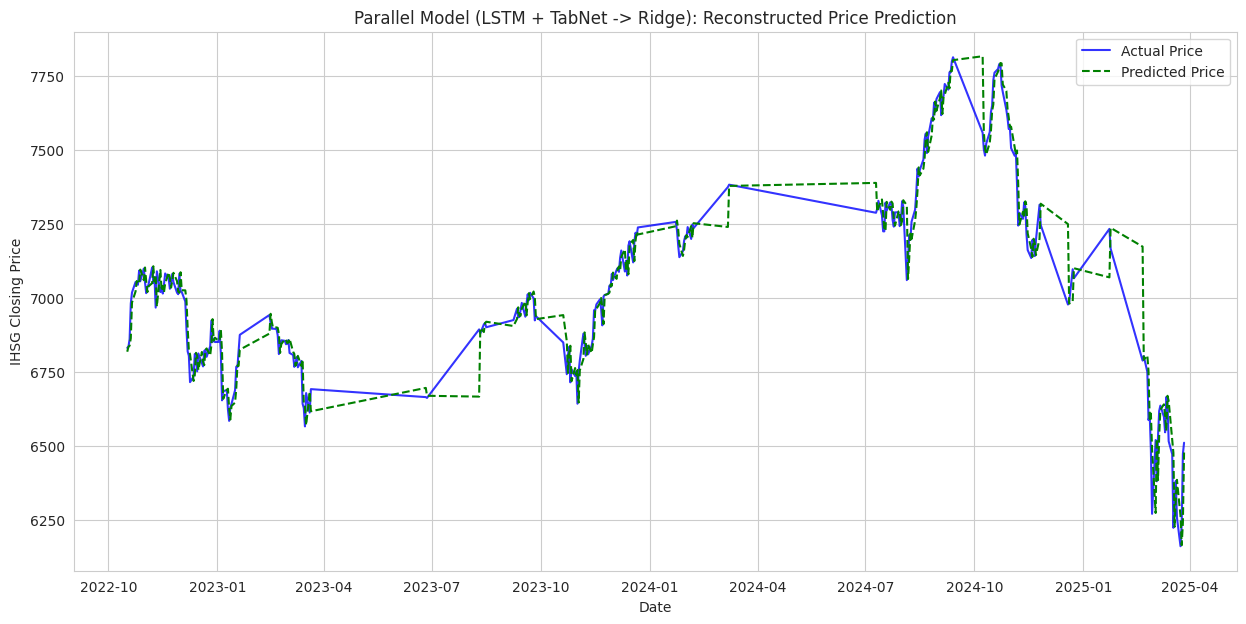


Generating TabNet's built-in interpretability plots...


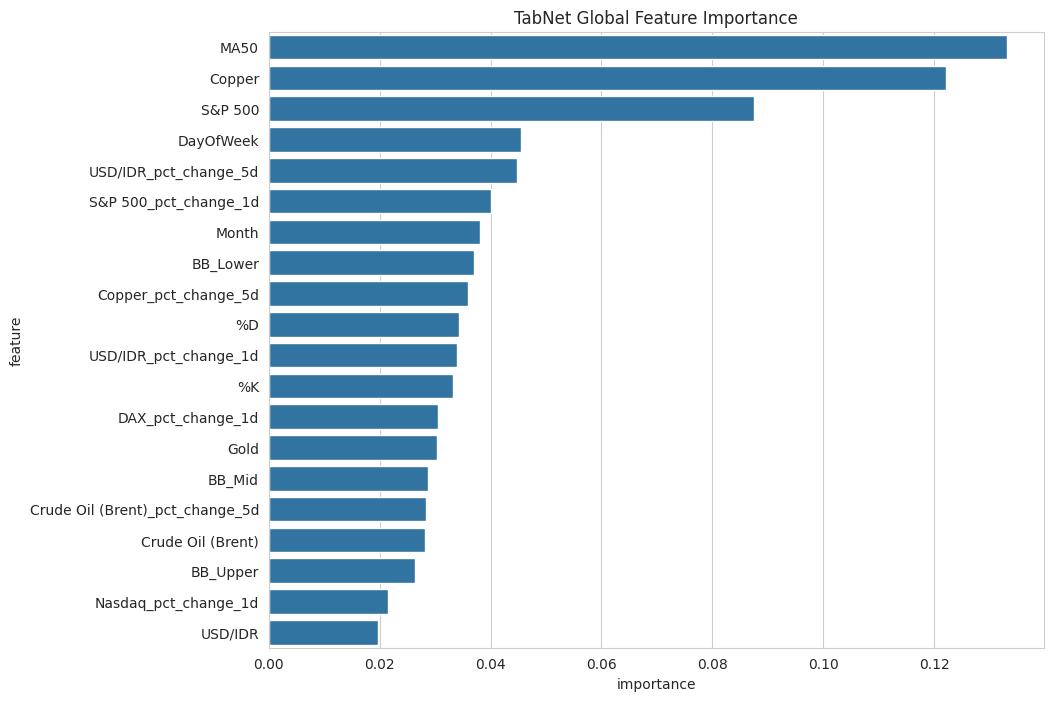

In [8]:
# ===================================================================
# 7. Evaluation and Interpretability
# ===================================================================
print("\nStep 7: Evaluating final model and generating plots...")

# --- Inverse transform predicted returns ---
final_predicted_returns = scaler_y.inverse_transform(final_predictions_scaled.reshape(-1, 1)).flatten()
y_test_returns_actual = y_test.iloc[TIME_STEPS:].values

# --- Reconstruct price prediction from returns ---
last_known_prices = data['IHSG'].iloc[train_size + TIME_STEPS -1:-1].values
reconstructed_price_pred = last_known_prices * (1 + final_predicted_returns)
y_test_price_actual = data['IHSG'].iloc[train_size + TIME_STEPS:].values

# --- Metrics ---
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

print("\n--- Performance on Returns ---")
print(f"RMSE (returns): {np.sqrt(mean_squared_error(y_test_returns_actual, final_predicted_returns)):.6f}")
print(f"MAE (returns):  {mean_absolute_error(y_test_returns_actual, final_predicted_returns):.6f}")

print("\n--- Performance on Reconstructed Price ---")
print(f"RMSE (price): {np.sqrt(mean_squared_error(y_test_price_actual, reconstructed_price_pred)):.2f}")
print(f"MAE (price):  {mean_absolute_error(y_test_price_actual, reconstructed_price_pred):.2f}")
print(f"R² (price):   {r2_score(y_test_price_actual, reconstructed_price_pred):.4f}")
print(f"SMAPE (price): {smape(y_test_price_actual, reconstructed_price_pred):.2f}%")

# --- Plotting ---
plt.figure(figsize=(15, 7))
plt.plot(y_test.index[TIME_STEPS:], y_test_price_actual, label='Actual Price', color='blue', alpha=0.8)
plt.plot(y_test.index[TIME_STEPS:], reconstructed_price_pred, label='Predicted Price', color='green', linestyle='--')
plt.title('Parallel Model (LSTM + TabNet -> Ridge): Reconstructed Price Prediction')
plt.xlabel('Date')
plt.ylabel('IHSG Closing Price')
plt.legend()
plt.show()

# --- TabNet's Built-in Interpretability ---
print("\nGenerating TabNet's built-in interpretability plots...")
importance_df = pd.DataFrame({
    'feature': features,
    'importance': final_tabnet_model.feature_importances_
}).sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.head(20))
plt.title('TabNet Global Feature Importance')
plt.show()
